In [1]:
import numpy as np
import pandas as pd
import polars as pl
import sys
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
import psycopg2

# CYP2C19 Gene

In [2]:
def read_bed_file(bed_file):
    bed_positions = set()
    with open(bed_file, 'r') as f:
        for line in f:
            if line.startswith('#'):  # Skip header lines if present
                continue
            fields = line.strip().split('\t')
            if len(fields) >= 3:
                chrom = fields[0]
                try:
                    start = int(fields[1])
                    end = int(fields[2])
                except ValueError:
                    continue  # Skip this line if start or end position is not an integer
                for pos in range(start, end + 1):
                    bed_positions.add((chrom, pos))
    return bed_positions

def normalize_chrom_name(chrom):
    return chrom.split('_')[0]

def filter_vcf_file(vcf_file, bed_positions):
    filtered_vcf_records = []
    with open(vcf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):  # Preserve header lines in the output
                filtered_vcf_records.append(line)
                continue
            fields = line.strip().split('\t')
            if len(fields) >= 2:
                raw_chrom = fields[0]
                chrom = normalize_chrom_name(raw_chrom)
                try:
                    pos = int(fields[1])
                except ValueError:
                    continue  # Skip this line if 'POS' is not an integer
                if (chrom, pos) in bed_positions:
                    filtered_vcf_records.append(line)
    return filtered_vcf_records

def write_filtered_vcf(filtered_vcf_records, output_file):
    with open(output_file, 'w') as f:
        for record in filtered_vcf_records:
            f.write(record)

def main():
    bed_file = r'C:/Users/GenepoweRx_Madhu/Downloads/BED_files/srinivas_sir_covered.bed'
    input_folder = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/LD/'
    output_folder = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/LD/covered/'

    bed_positions = read_bed_file(bed_file)

    vcf_files = [f for f in os.listdir(input_folder) if f.endswith('.vcf')]

    for vcf_file in vcf_files:
        input_file_path = os.path.join(input_folder, vcf_file)
        output_file_path = os.path.join(output_folder, vcf_file)
        filtered_vcf_records = filter_vcf_file(input_file_path, bed_positions)
        write_filtered_vcf(filtered_vcf_records, output_file_path)

if __name__ == "__main__":
    main()

In [17]:
def process_vcf_files(folder_path):
    vcf_list = []
    
    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".vcf"):  # Assuming all files in the folder are VCF files
            vcf_path = os.path.join(folder_path, filename)
            vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
            vcf.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
            
            # Extract additional columns
            sample_cols = vcf['SAMPLE'].str.split(':', expand=True)
            sample_cols.columns = ['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'Rvcf', 'RDR', 'Avcf', 'ADR']
            vcf = pd.concat([vcf, sample_cols], axis=1)
            
            def map_genotype(value):
                if '1/1' in value:
                    return 'HOM'
                elif '0/1' in value:
                    return 'HET'
                else:
                    return 'HET'  # Updated to 'HET' as default since '0/0' typically represents homozygous reference
            
            vcf['Zygosity'] = vcf['GT'].apply(map_genotype)
            vcf["Gene Name"] = vcf["INFO"].str.extract('GENEINFO=(?P<GENEINFO>.+?);')
            vcf['Gene Name'] = vcf['Gene Name'].apply(lambda x: ','.join(set([segment.split(':')[0] for segment in x.split('|')])) if pd.notnull(x) else '')
            vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
            vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
            vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
            vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
            vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0).astype('float')
            
            # Add a new column with the file name
            vcf['File_Name'] = filename.split('_')[0]
            
            data = {'Gene Name': ['CYP2C19']}
            df_gene = pd.DataFrame(data)
            
            vcf['Gene_Match'] = 'No'
            # Iterate through each gene in vcf['Gene Name']
            for genes in vcf['Gene Name']:
                if isinstance(genes, str):  # Check if the gene value is a non-null string
                    gene_list = genes.split(',')  # Split the genes by comma to create a list
                    match = any(gene in df_gene['Gene Name'].values for gene in gene_list)  # Check if any gene in the list exists in df_gene
                    if match:
                        vcf.loc[vcf['Gene Name'] == genes, 'Gene_Match'] = 'Yes'
                        
            # Filter vcf based on 'Gene_Match' column
            matched_vcf = vcf[vcf['Gene_Match'] == 'Yes']
            matched_vcf['variant'] = matched_vcf['CHROM'].astype(str) + '_' + matched_vcf['POS'].astype(str) + '_' + matched_vcf['REF'].astype(str) + '_' + matched_vcf['ALT'].astype(str)
            
            vcf_list.append(matched_vcf)
    
    if not vcf_list:
        return None
    
    merged_vcf = pd.concat(vcf_list, ignore_index=True)
    return merged_vcf

# Example usage:
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/LD/covered/'
final_vcf = process_vcf_files(folder_path)
# Counting the occurrence of each variant
variant_counts = final_vcf['variant'].value_counts()

# Filtering variants that are present in all samples
variants_in_all_samples = variant_counts[variant_counts == final_vcf['File_Name'].nunique()].index.tolist()

# Filtering the DataFrame to include only rows with variants present in all samples
rows_in_all_samples = final_vcf[final_vcf['variant'].isin(variants_in_all_samples)]
rows_in_all_samples

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RBQ,ABQ,Rvcf,RDR,Avcf,ADR,Zygosity,Gene Name,CSQ,gnomADe_SAS_AF,gnomADe_AF,File_Name,Gene_Match,variant
0,chr10,94762804,rs17885098,C,T,.,PASS,"ADP=48;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.9081,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:48:48:0:48:100%:1.554E-28:0:58:0:0:36:12,1/1,255,48,48,0,48,100%,1.554E-28,0,58,0,0,36,12,HOM,CYP2C19,T|synonymous_variant|LOW|CYP2C19|ENSG000001658...,0.0,0.0,KHAIGPRX1307,Yes,chr10_94762804_C_T
2,chr10,94762804,rs17885098,C,T,.,PASS,"ADP=41;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.9081,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:236:41:41:0:41:100%:2.3541E-24:0:55:0:0:30:11,1/1,236,41,41,0,41,100%,2.3541E-24,0,55,0,0,30,11,HOM,CYP2C19,T|synonymous_variant|LOW|CYP2C19|ENSG000001658...,0.0,0.0,KHAIGPRX1365,Yes,chr10_94762804_C_T
4,chr10,94762804,rs17885098,C,T,.,PASS,"ADP=37;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.9081,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:212:37:37:0:37:100%:5.7269E-22:0:45:0:0:23:14,1/1,212,37,37,0,37,100%,5.7269E-22,0,45,0,0,23,14,HOM,CYP2C19,T|synonymous_variant|LOW|CYP2C19|ENSG000001658...,0.0,0.0,KHAIGPRX1392,Yes,chr10_94762804_C_T
8,chr10,94762804,rs17885098,C,T,.,PASS,"ADP=40;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9081,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:44:40:40:27:13:32.5%:3.8184E-5:58:61:24:3:...,0/1,44,40,40,27,13,32.5%,3.8184E-5,58,61,24,3,12,1,HET,CYP2C19,T|synonymous_variant|LOW|CYP2C19|ENSG000001658...,0.0,0.0,KHAIGPRX1441,Yes,chr10_94762804_C_T
10,chr10,94762804,rs17885098,C,T,.,PASS,"ADP=45;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.9081,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:45:45:0:45:100%:9.6314E-27:0:55:0:0:37:8,1/1,255,45,45,0,45,100%,9.6314E-27,0,55,0,0,37,8,HOM,CYP2C19,T|synonymous_variant|LOW|CYP2C19|ENSG000001658...,0.0,0.0,KHAIGPRX1442,Yes,chr10_94762804_C_T


In [18]:
def process_vcf_files(folder_path):
    vcf_list = []
    
    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".vcf"):  # Assuming all files in the folder are VCF files
            vcf_path = os.path.join(folder_path, filename)
            vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
            vcf.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
            
            # Extract additional columns
            sample_cols = vcf['SAMPLE'].str.split(':', expand=True)
            sample_cols.columns = ['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'Rvcf', 'RDR', 'Avcf', 'ADR']
            vcf = pd.concat([vcf, sample_cols], axis=1)
            
            def map_genotype(value):
                if '1/1' in value:
                    return 'HOM'
                elif '0/1' in value:
                    return 'HET'
                else:
                    return 'HET'  # Updated to 'HET' as default since '0/0' typically represents homozygous reference
            
            vcf['Zygosity'] = vcf['GT'].apply(map_genotype)
            vcf["Gene Name"] = vcf["INFO"].str.extract('GENEINFO=(?P<GENEINFO>.+?);')
            vcf['Gene Name'] = vcf['Gene Name'].apply(lambda x: ','.join(set([segment.split(':')[0] for segment in x.split('|')])) if pd.notnull(x) else '')
            vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
            vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
            vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
            vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
            vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0).astype('float')
            
            # Add a new column with the file name
            vcf['File_Name'] = filename.split('_')[0]
            
            data = {'Gene Name': ['CYP3A5']}
            df_gene = pd.DataFrame(data)
            
            vcf['Gene_Match'] = 'No'
            # Iterate through each gene in vcf['Gene Name']
            for genes in vcf['Gene Name']:
                if isinstance(genes, str):  # Check if the gene value is a non-null string
                    gene_list = genes.split(',')  # Split the genes by comma to create a list
                    match = any(gene in df_gene['Gene Name'].values for gene in gene_list)  # Check if any gene in the list exists in df_gene
                    if match:
                        vcf.loc[vcf['Gene Name'] == genes, 'Gene_Match'] = 'Yes'
                        
            # Filter vcf based on 'Gene_Match' column
            matched_vcf = vcf[vcf['Gene_Match'] == 'Yes']
            matched_vcf['variant'] = matched_vcf['CHROM'].astype(str) + '_' + matched_vcf['POS'].astype(str) + '_' + matched_vcf['REF'].astype(str) + '_' + matched_vcf['ALT'].astype(str)
            
            vcf_list.append(matched_vcf)
    
    if not vcf_list:
        return None
    
    merged_vcf = pd.concat(vcf_list, ignore_index=True)
    return merged_vcf

# Example usage:
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/LD/covered/'
final_vcf = process_vcf_files(folder_path)
# Counting the occurrence of each variant
variant_counts = final_vcf['variant'].value_counts()

# Filtering variants that are present in all samples
variants_in_all_samples = variant_counts[variant_counts == final_vcf['File_Name'].nunique()].index.tolist()

# Filtering the DataFrame to include only rows with variants present in all samples
rows_in_all_samples = final_vcf[final_vcf['variant'].isin(variants_in_all_samples)]
rows_in_all_samples

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RBQ,ABQ,Rvcf,RDR,Avcf,ADR,Zygosity,Gene Name,CSQ,gnomADe_SAS_AF,gnomADe_AF,File_Name,Gene_Match,variant
0,chr7,99648291,rs15524,A,G,.,PASS,"ADP=18;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.652,0.3...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:32:18:18:9:9:50%:5.1645E-4:48:57:9:0:6:3,0/1,32,18,18,9,9,50%,5.1645E-4,48,57,9,0,6,3,HET,"CYP3A5,ZSCAN25",G|3_prime_UTR_variant|MODIFIER|CYP3A5|ENSG0000...,0.2844,0.1703,KHAIGPRX1365,Yes,chr7_99648291_A_G
1,chr7,99648291,rs15524,A,G,.,PASS,"ADP=20;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.652,0.3...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:51:20:20:7:13:65%:6.4422E-6:54:61:5:2:10:3,0/1,51,20,20,7,13,65%,6.4422E-6,54,61,5,2,10,3,HET,"CYP3A5,ZSCAN25",G|3_prime_UTR_variant|MODIFIER|CYP3A5|ENSG0000...,0.2844,0.1703,KHAIGPRX1441,Yes,chr7_99648291_A_G


In [29]:
def process_vcf_files(folder_path):
    vcf_list = []
    
    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".vcf"):  # Assuming all files in the folder are VCF files
            vcf_path = os.path.join(folder_path, filename)
            vcf = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
            vcf.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
            
            # Extract additional columns
            sample_cols = vcf['SAMPLE'].str.split(':', expand=True)
            sample_cols.columns = ['GT', 'GQ', 'SDP', 'DP', 'RD', 'AD', 'FREQ', 'PVAL', 'RBQ', 'ABQ', 'Rvcf', 'RDR', 'Avcf', 'ADR']
            vcf = pd.concat([vcf, sample_cols], axis=1)
            
            def map_genotype(value):
                if '1/1' in value:
                    return 'HOM'
                elif '0/1' in value:
                    return 'HET'
                else:
                    return 'HET'  # Updated to 'HET' as default since '0/0' typically represents homozygous reference
            
            vcf['Zygosity'] = vcf['GT'].apply(map_genotype)
            vcf["Gene Name"] = vcf["INFO"].str.extract('GENEINFO=(?P<GENEINFO>.+?);')
            vcf['Gene Name'] = vcf['Gene Name'].apply(lambda x: ','.join(set([segment.split(':')[0] for segment in x.split('|')])) if pd.notnull(x) else '')
            vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
            vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
            vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
            vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
            vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0).astype('float')
            
            # Add a new column with the file name
            vcf['File_Name'] = filename.split('_')[0]
            
            data = {'Gene Name': ['NAT1']}
            df_gene = pd.DataFrame(data)
            
            vcf['Gene_Match'] = 'No'
            # Iterate through each gene in vcf['Gene Name']
            for genes in vcf['Gene Name']:
                if isinstance(genes, str):  # Check if the gene value is a non-null string
                    gene_list = genes.split(',')  # Split the genes by comma to create a list
                    match = any(gene in df_gene['Gene Name'].values for gene in gene_list)  # Check if any gene in the list exists in df_gene
                    if match:
                        vcf.loc[vcf['Gene Name'] == genes, 'Gene_Match'] = 'Yes'
                        
            # Filter vcf based on 'Gene_Match' column
            matched_vcf = vcf[vcf['Gene_Match'] == 'Yes']
            matched_vcf['variant'] = matched_vcf['CHROM'].astype(str) + '_' + matched_vcf['POS'].astype(str) + '_' + matched_vcf['REF'].astype(str) + '_' + matched_vcf['ALT'].astype(str)
            
            vcf_list.append(matched_vcf)
    
    if not vcf_list:
        return None
    
    merged_vcf = pd.concat(vcf_list, ignore_index=True)
    return merged_vcf

# Example usage:
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/vcf_files_all/LD/covered/'
final_vcf = process_vcf_files(folder_path)
# Counting the occurrence of each variant
variant_counts = final_vcf['variant'].value_counts()

# Filtering variants that are present in all samples
variants_in_all_samples = variant_counts[variant_counts == final_vcf['File_Name'].nunique()].index.tolist()

# Filtering the DataFrame to include only rows with variants present in all samples
rows_in_all_samples = final_vcf[final_vcf['variant'].isin(variants_in_all_samples)]
rows_in_all_samples

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,GT,GQ,SDP,DP,RD,AD,FREQ,PVAL,RBQ,ABQ,Rvcf,RDR,Avcf,ADR,Zygosity,Gene Name,CSQ,gnomADe_SAS_AF,gnomADe_AF,File_Name,Gene_Match,variant
0,chr8,18217027,rs7387461,G,A,.,PASS,ADP=31;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=N...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:176:31:31:0:31:100%:2.1486E-18:0:52:0:0:19:12,1/1,176,31,31,0,31,100%,2.1486E-18,0,52,0,0,19,12,HOM,NAT1,A|intron_variant|MODIFIER|NAT1|ENSG00000171428...,0.9586,0.9178,KHAIGPRX1307,Yes,chr8_18217027_G_A
5,chr8,18217027,rs7387461,G,A,.,PASS,ADP=21;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=N...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:117:21:21:0:21:100%:1.8578E-12:0:57:0:0:14:7,1/1,117,21,21,0,21,100%,1.8578E-12,0,57,0,0,14,7,HOM,NAT1,A|intron_variant|MODIFIER|NAT1|ENSG00000171428...,0.9586,0.9178,KHAIGPRX1365,Yes,chr8_18217027_G_A
6,chr8,18217027,rs7387461,G,A,.,PASS,ADP=17;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=N...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:93:17:17:0:17:100%:4.2852E-10:0:42:0:0:4:13,1/1,93,17,17,0,17,100%,4.2852E-10,0,42,0,0,4,13,HOM,NAT1,A|intron_variant|MODIFIER|NAT1|ENSG00000171428...,0.9586,0.9178,KHAIGPRX1392,Yes,chr8_18217027_G_A
7,chr8,18217027,rs7387461,G,A,.,PASS,ADP=17;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=N...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:93:17:17:0:17:100%:4.2852E-10:0:59:0:0:13:4,1/1,93,17,17,0,17,100%,4.2852E-10,0,59,0,0,13,4,HOM,NAT1,A|intron_variant|MODIFIER|NAT1|ENSG00000171428...,0.9586,0.9178,KHAIGPRX1441,Yes,chr8_18217027_G_A
8,chr8,18217027,rs7387461,G,A,.,PASS,ADP=15;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=N...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:81:15:15:0:15:100%:6.4467E-9:0:67:0:0:13:2,1/1,81,15,15,0,15,100%,6.4467E-9,0,67,0,0,13,2,HOM,NAT1,A|intron_variant|MODIFIER|NAT1|ENSG00000171428...,0.9586,0.9178,KHAIGPRX1442,Yes,chr8_18217027_G_A


In [28]:
import pandas as pd
import allel
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data
data = {
    'Sample_ID': list(range(1, 21)),
    'Variant1': ['A/A', 'A/A', 'A/A', 'A/A', 'A/A', 'A/G', 'A/A', 'A/A', 'A/A', 'A/G',
                 'A/A', 'A/A', 'A/A', 'A/A', 'A/A', 'A/G', 'A/A', 'A/A', 'A/A', 'A/G'],
    'Variant2': ['G/G', 'G/G', 'G/A', 'G/G', 'G/A', 'G/G', 'G/G', 'G/G', 'G/G', 'G/A',
                 'G/G', 'G/G', 'G/A', 'G/G', 'G/A', 'G/G', 'G/G', 'G/G', 'G/G', 'G/A'],
    'Variant3': ['T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T',
                 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T', 'T/T']
}

# Create DataFrame
genotype_data = pd.DataFrame(data)

# Define a function to convert genotype strings to numerical codes
def convert_genotype_to_numeric(genotype_str):
    if genotype_str == 'A/A':
        return 0
    elif genotype_str == 'A/G' or genotype_str == 'G/A':
        return 1
    elif genotype_str == 'G/G':
        return 2
    else:
        return np.nan  # Handle missing data or unknown genotypes

# Convert genotype data to numerical format
genotype_data_numeric = genotype_data.drop(columns='Sample_ID').applymap(convert_genotype_to_numeric)

# Convert DataFrame to numpy array
genotypes = genotype_data_numeric.to_numpy()

# Calculate LD
ld = allel.rogers_huff_r(genotypes)

# Plot LD heatmap
sns.heatmap(ld, cmap='coolwarm', xticklabels=genotype_data.columns[1:], yticklabels=genotype_data.columns[1:])
plt.title('LD Heatmap')
plt.xlabel('Variant')
plt.ylabel('Variant')
plt.show()

# LD decay plot (plotting r^2 against physical distance)
# Assuming you have physical positions for your variants
# Here, we create dummy positions for demonstration purposes
positions = pd.DataFrame({'Position': range(1, len(genotype_data.columns))})

# Calculate physical distances
physical_distances = abs(positions['Position'].values[:, None] - positions['Position'].values)

# Calculate r^2
r2 = allel.rogers_huff_r2(genotypes)

# Flatten physical distances and r^2 arrays for plotting
physical_distances_flat = physical_distances.flatten()
r2_flat = r2.flatten()

# Plot LD decay
plt.plot(physical_distances_flat, r2_flat, '.')
plt.title('LD Decay Plot')
plt.xlabel('Physical Distance')
plt.ylabel('r^2')
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (190, 1) and (190,))

# Prevalence

In [9]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Prevalence_SNPs_PharmaGKB.xlsx')
df_new = df[0:8]
df_new

,Chr,POS,Ref,Alt,rsID,variant,Consequence,Exon/Intron_number,Total_Exons/Introns,Gene_Symbol,Star_Allele,Count,Heterozygous,Homozygous_Mutant,Wild,Percentage,Ref_count,Alt_Count,Allele_Count,Ref_Freq,Alt_Allele_Freq
0,chr4,88131171,G,T,rs2231142,chr4_88131171_G_T,missense_variant,Exon5,16.0,ABCG2,NaN,236,219,17.0,996,19.155844,2211,253,2464,0.897321,0.102679
1,chr4,2904980,G,T,rs4961,chr4_2904980_G_T,missense_variant,Exon10,15.0,ADD1,NaN,416,353,63.0,816,33.766234,1985,479,2464,0.805601,0.194399
2,chr5,148826877,G,A,rs1042713,chr5_148826877_G_A,missense_variant,Exon1,1.0,ADRB2,NaN,714,507,207.0,518,57.954545,1543,921,2464,0.626218,0.373782
3,chr19,44908822,C,T,rs7412,chr19_44908822_C_T,missense_variant,Exon4,4.0,APOE,NaN,83,80,3.0,1149,6.737013,2378,86,2464,0.965097,0.034903
4,chr2,215347616,T,C,rs4673993,chr2_215347616_T_C,intron_variant,Intron14,15.0,ATIC,NaN,775,490,285.0,457,62.905844,1404,1060,2464,0.569805,0.430195
5,chr16,55823658,C,T,rs71647871,chr16_55823658_C_T,missense_variant,Exon4,14.0,CES1,NaN,9,9,NaN,1223,0.730519,2455,9,2464,0.996347,0.003653
6,chr7,117611650,G,A,rs78769542,chr7_117611650_G_A,missense_variant,Exon20,27.0,CFTR,R1070Q,7,6,1.0,1225,0.568182,2456,8,2464,0.996753,0.003247
7,chr15,78590583,G,A,rs16969968,chr15_78590583_G_A,missense_variant,Exon5,5.0,CHRNA5,NaN,382,340,42.0,850,31.006494,2040,424,2464,0.827922,0.172078


In [14]:
import numpy as np

# SNP data
SNP1_allele_counts = {'G': 219, 'T': 2245}
SNP2_allele_counts = {'G': 507, 'A': 1357}

# Total sample size
total_samples = 2464

# Calculate allele frequencies
SNP1_af = SNP1_allele_counts['T'] / total_samples
SNP2_af = SNP2_allele_counts['A'] / total_samples

# Calculate haplotype frequencies
haplotype_counts = {
    ('T', 'A'): 382,  # Example: Count of haplotype 'TA'
    ('T', 'G'): 2134, # Example: Count of haplotype 'TG'
    ('G', 'A'): 122,  # Example: Count of haplotype 'GA'
    ('G', 'G'): 826   # Example: Count of haplotype 'GG'
}

# Calculate haplotype frequencies
haplotype_freq = {hap: count / total_samples for hap, count in haplotype_counts.items()}

# Calculate LD (r^2)
D = haplotype_freq[('T', 'A')] - (SNP1_af * SNP2_af)
r_squared = D**2 / (SNP1_af * (1 - SNP1_af) * SNP2_af * (1 - SNP2_af))

print("LD (r^2):", r_squared)


LD (r^2): 6.000753788816299


In [20]:
import pandas as pd
import itertools

# Load data into a pandas DataFrame
data = {
    "rsID": ["rs2231142", "rs4961", "rs1042713", "rs7412", "rs4673993", "rs71647871", "rs78769542", "rs16969968"],
    "allele_counts": [
        {'G': 219, 'T': 2245},
        {'G': 353, 'T': 63},
        {'G': 507, 'A': 207},
        {'C': 80, 'T': 3},
        {'T': 490, 'C': 285},
        {'C': 9, 'T': 9},
        {'G': 7, 'A': 7},
        {'G': 382, 'A': 382}
    ],
    "total_samples": [2464]*8
}

df = pd.DataFrame(data)
df

,rsID,allele_counts,total_samples
0,rs2231142,"{'G': 219, 'T': 2245}",2464
1,rs4961,"{'G': 353, 'T': 63}",2464
2,rs1042713,"{'G': 507, 'A': 207}",2464
3,rs7412,"{'C': 80, 'T': 3}",2464
4,rs4673993,"{'T': 490, 'C': 285}",2464
5,rs71647871,"{'C': 9, 'T': 9}",2464
6,rs78769542,"{'G': 7, 'A': 7}",2464
7,rs16969968,"{'G': 382, 'A': 382}",2464


In [22]:
import pandas as pd
import itertools

# Load data into a pandas DataFrame
data = {
    "rsID": ["rs2231142", "rs4961", "rs1042713", "rs7412", "rs4673993", "rs71647871", "rs78769542", "rs16969968"],
    "allele_counts": [
        {'G': 219, 'T': 2245},
        {'G': 353, 'T': 63},
        {'G': 507, 'A': 207},
        {'C': 80, 'T': 3},
        {'T': 490, 'C': 285},
        {'C': 9, 'T': 9},
        {'G': 7, 'A': 7},
        {'G': 382, 'A': 382}
    ],
    "total_samples": [2464]*8
}

df = pd.DataFrame(data)

# Calculate allele frequencies
df['allele_freq'] = df.apply(lambda row: {allele: count / row['total_samples'] for allele, count in row['allele_counts'].items()}, axis=1)

# Initialize an empty DataFrame to store LD results
ld_results = pd.DataFrame(columns=['rsID1', 'rsID2', 'r'])

# Calculate LD for all combinations of rsIDs
for rsID1, rsID2 in itertools.combinations(df['rsID'], 2):
    # Get allele frequencies for each SNP
    af1 = df.loc[df['rsID'] == rsID1, 'allele_freq'].iloc[0]
    af2 = df.loc[df['rsID'] == rsID2, 'allele_freq'].iloc[0]
    
    # Find common alleles
    common_alleles = set(af1.keys()) & set(af2.keys())
    
    # Calculate Pearson correlation coefficient (r) as a measure of LD
    if common_alleles:
        numerator = sum((af1[allele] - sum(af1.values()) * af2[allele]) * (af2[allele] - sum(af2.values()) * af1[allele]) for allele in common_alleles)
        denominator1 = sum((af1[allele] - sum(af1.values()) * af1[allele]) ** 2 for allele in common_alleles)
        denominator2 = sum((af2[allele] - sum(af2.values()) * af2[allele]) ** 2 for allele in common_alleles)
        
        if denominator1 != 0 and denominator2 != 0:  # Check if both denominators are non-zero
            r = numerator / (denominator1 ** 0.5 * denominator2 ** 0.5)
        else:
            r = 0  # If one of the denominators is zero, set r to 0
    else:
        r = 0  # If there are no common alleles, set r to 0
    
    # Append LD results to the DataFrame
    ld_results = ld_results.append({'rsID1': rsID1, 'rsID2': rsID2, 'r': r}, ignore_index=True)

# Display the LD results
ld_results

,rsID1,rsID2,r
0,rs2231142,rs4961,0
1,rs2231142,rs1042713,0
2,rs2231142,rs7412,0
3,rs2231142,rs4673993,0
4,rs2231142,rs71647871,0
5,rs2231142,rs78769542,0
6,rs2231142,rs16969968,0
7,rs4961,rs1042713,1.024332
8,rs4961,rs7412,0.361394
9,rs4961,rs4673993,-0.527376


In [23]:
import pandas as pd
import itertools

# Load data into a pandas DataFrame
data = {
    "rsID": ["rs2231142", "rs4961", "rs1042713", "rs7412", "rs4673993", "rs71647871", "rs78769542", "rs16969968"],
    "allele_counts": [
        {'G': 219, 'T': 2245},
        {'G': 353, 'T': 63},
        {'G': 507, 'A': 207},
        {'C': 80, 'T': 3},
        {'T': 490, 'C': 285},
        {'C': 9, 'T': 9},
        {'G': 7, 'A': 7},
        {'G': 382, 'A': 382}
    ],
    "total_samples": [2464]*8
}

df = pd.DataFrame(data)

# Calculate allele frequencies
df['allele_freq'] = df.apply(lambda row: {allele: count / row['total_samples'] for allele, count in row['allele_counts'].items()}, axis=1)

# Initialize an empty DataFrame to store LD results
ld_results = pd.DataFrame(columns=['rsID1', 'rsID2', 'r_squared'])

# Calculate LD for all combinations of rsIDs
for rsID1, rsID2 in itertools.combinations(df['rsID'], 2):
    # Get allele frequencies for each SNP
    af1 = df.loc[df['rsID'] == rsID1, 'allele_freq'].iloc[0]
    af2 = df.loc[df['rsID'] == rsID2, 'allele_freq'].iloc[0]
    
    # Find common alleles
    common_alleles = set(af1.keys()) & set(af2.keys())
    
    # Calculate Pearson correlation coefficient (r) as a measure of LD
    if common_alleles:
        numerator = sum((af1[allele] - sum(af1.values()) * af2[allele]) * (af2[allele] - sum(af2.values()) * af1[allele]) for allele in common_alleles)
        denominator1 = sum((af1[allele] - sum(af1.values()) * af1[allele]) ** 2 for allele in common_alleles)
        denominator2 = sum((af2[allele] - sum(af2.values()) * af2[allele]) ** 2 for allele in common_alleles)
        
        if denominator1 != 0 and denominator2 != 0:  # Check if both denominators are non-zero
            r = numerator / (denominator1 ** 0.5 * denominator2 ** 0.5)
            r_squared = r**2  # Square the Pearson correlation coefficient to get r^2
        else:
            r_squared = 0  # If one of the denominators is zero, set r^2 to 0
    else:
        r_squared = 0  # If there are no common alleles, set r^2 to 0
    
    # Append LD results to the DataFrame
    ld_results = ld_results.append({'rsID1': rsID1, 'rsID2': rsID2, 'r_squared': r_squared}, ignore_index=True)

# Display the LD results
ld_results

,rsID1,rsID2,r_squared
0,rs2231142,rs4961,0
1,rs2231142,rs1042713,0
2,rs2231142,rs7412,0
3,rs2231142,rs4673993,0
4,rs2231142,rs71647871,0
5,rs2231142,rs78769542,0
6,rs2231142,rs16969968,0
7,rs4961,rs1042713,1.049255
8,rs4961,rs7412,0.130606
9,rs4961,rs4673993,0.278126


# Main Linkage Disequilibrium setup

In [28]:
import pandas as pd
import itertools

# Load data into a pandas DataFrame
data = {
    "rsID": ["rs2231142", "rs4961", "rs1042713", "rs7412", "rs4673993", "rs71647871", "rs78769542", "rs16969968"],
    "allele_counts": [
        {'G': 219, 'T': 2245},
        {'G': 353, 'T': 63},
        {'G': 507, 'A': 207},
        {'C': 80, 'T': 3},
        {'T': 490, 'C': 285},
        {'C': 9, 'T': 9},
        {'G': 7, 'A': 7},
        {'G': 382, 'A': 382}
    ],
    "total_samples": [1232]*8
}

df = pd.DataFrame(data)

# Calculate allele frequencies
df['allele_freq'] = df.apply(lambda row: {allele: count / row['total_samples'] for allele, count in row['allele_counts'].items()}, axis=1)

# Initialize an empty DataFrame to store LD results
ld_results = pd.DataFrame(columns=['rsID1', 'rsID2', 'r_squared'])

# Calculate LD for all combinations of rsIDs
for rsID1, rsID2 in itertools.combinations(df['rsID'], 2):
    # Get allele frequencies for each SNP
    af1 = df.loc[df['rsID'] == rsID1, 'allele_freq'].iloc[0]
    af2 = df.loc[df['rsID'] == rsID2, 'allele_freq'].iloc[0]
    
    # Find common alleles
    common_alleles = set(af1.keys()) & set(af2.keys())
    
    # Calculate Pearson correlation coefficient (r) as a measure of LD
    if common_alleles:
        numerator = sum((af1[allele] - sum(af1.values()) * af2[allele]) * (af2[allele] - sum(af2.values()) * af1[allele]) for allele in common_alleles)
        denominator1 = sum((af1[allele] - sum(af1.values()) * af1[allele]) ** 2 for allele in common_alleles)
        denominator2 = sum((af2[allele] - sum(af2.values()) * af2[allele]) ** 2 for allele in common_alleles)
        
        if denominator1 != 0 and denominator2 != 0:  # Check if both denominators are non-zero
            r = numerator / (denominator1 ** 0.5 * denominator2 ** 0.5)
            r_squared = min(max(r**2, 0), 1)  # Ensure r^2 falls within the range [0, 1]
        else:
            r_squared = 0  # If one of the denominators is zero, set r^2 to 0
    else:
        r_squared = 0  # If there are no common alleles, set r^2 to 0
    
    # Append LD results to the DataFrame
    ld_results = ld_results.append({'rsID1': rsID1, 'rsID2': rsID2, 'r_squared': r_squared}, ignore_index=True)

# Display the LD results
ld_results

,rsID1,rsID2,r_squared
0,rs2231142,rs4961,1
1,rs2231142,rs1042713,1
2,rs2231142,rs7412,1
3,rs2231142,rs4673993,1
4,rs2231142,rs71647871,1
5,rs2231142,rs78769542,0.372362
6,rs2231142,rs16969968,1
7,rs4961,rs1042713,1
8,rs4961,rs7412,0.436479
9,rs4961,rs4673993,1


# Linkage disequilibrium (LD) refers to the non-random association of the alleles at a pair of genetic loci.

In [13]:
import numpy as np
from itertools import combinations

# Function to calculate LD (r^2)
def calculate_ld(observed):
    n = np.sum(observed)
    allele_freqs = observed / n
    expected = np.outer(allele_freqs, allele_freqs)
    ld_matrix = (observed - expected) ** 2 / expected
    r_squared = np.sum(ld_matrix) / (n * np.min(allele_freqs) * np.min(1 - allele_freqs))
    return r_squared

# Sample data (allele counts)
allele_counts = {
    'rs2231142': {'G': 2211, 'T': 253},
    'rs4961': {'G': 1985, 'T': 479},
    # Add more SNP allele counts here...
}

# Calculate LD between pairs of SNPs
ld_results = {}
for snp1, snp2 in combinations(allele_counts.keys(), 2):
    alleles_snp1 = allele_counts[snp1]
    alleles_snp2 = allele_counts[snp2]
    
    # Assuming only biallelic SNPs, you can adjust if needed for multi-allelic SNPs
    alleles = list(set(alleles_snp1.keys()) | set(alleles_snp2.keys()))
    
    observed = np.zeros((len(alleles), len(alleles)), dtype=int)
    for i, a1 in enumerate(alleles):
        for j, a2 in enumerate(alleles):
            observed[i, j] = alleles_snp1.get(a1, 0) * alleles_snp2.get(a2, 0)
    
    r_squared = calculate_ld(observed)
    ld_results[(snp1, snp2)] = r_squared

# Output LD results
for pair, r_squared in ld_results.items():
    print(f"LD between {pair}: r^2 = {r_squared:.4f}")


ValueError: operands could not be broadcast together with shapes (2,2) (4,4) 

In [32]:
import pandas as pd
import numpy as np

# Example data
data = {
    'rsID': ['rs1', 'rs2', 'rs3', 'rs4', 'rs5'],  
    'Alt_Freq': [0.1, 0.2, 0.3, 0.4, 0.5],  
    'MAF_K&H': [0.15, 0.18, 0.25, 0.35, 0.45], 
    'Global': [0.08, 0.22, 0.28, 0.37, 0.48],
    'East_Asian': [0.12, 0.19, 0.27, 0.39, 0.51],
    'European(non-Finnish)': [0.11, 0.21, 0.29, 0.36, 0.47],
    'South_Asian': [0.09, 0.23, 0.26, 0.38, 0.49],
    'African/African_American': [0.07, 0.24, 0.3, 0.34, 0.55]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Calculate correlation coefficients for each population
correlations = {}
for population in ['Global', 'East_Asian', 'European(non-Finnish)', 'South_Asian', 'African/African_American']:
    correlation_coefficient = np.corrcoef(df['Alt_Freq'], df[population])[0, 1]
    correlations[population] = correlation_coefficient

# Print correlation coefficients
for population, correlation in correlations.items():
    print(f"Correlation coefficient between Asian population and {population}: {correlation}")

Correlation coefficient between Asian population and Global: 0.9930373868834202
Correlation coefficient between Asian population and East_Asian: 0.9923828021095931
Correlation coefficient between Asian population and European(non-Finnish): 0.9974336153522702
Correlation coefficient between Asian population and South_Asian: 0.9872294719251351
Correlation coefficient between Asian population and African/African_American: 0.9652331109844037


In [72]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Prevalence_SNPs_PharmaGKB_All_Level1&2_27_12_2023.xlsx')
df = df[['rsID', 'Alt_Freq/MAF_K&H', 'Global', 'East_Asian', 'European(non-Finnish)', 'South_Asian', 'African/African_American']]
df.head(3)

,rsID,Alt_Freq/MAF_K&H,Global,East_Asian,European(non-Finnish),South_Asian,African/African_American
0,rs2231142,0.102679,0.1119,0.2982,0.1109,0.09018,0.02677
1,rs4961,0.194399,0.1984,0.5080,0.1989,0.17500,0.07598
2,rs1042713,0.373782,0.3883,0.5276,0.3652,0.44830,0.49350


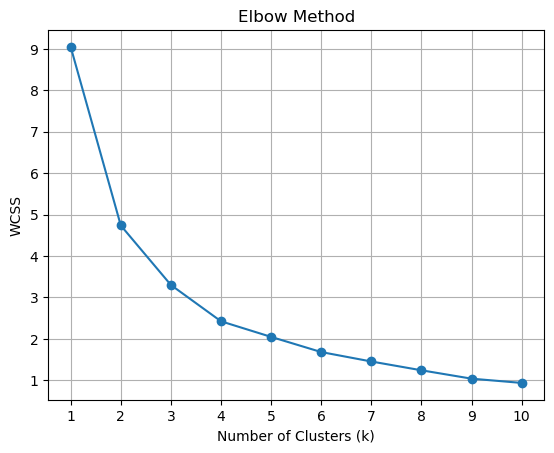

In [73]:
# Extract MAF values for clustering
maf_data = df[['Global', 'East_Asian', 'European(non-Finnish)', 'South_Asian', 'African/African_American']].values

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(maf_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [75]:
# Extract MAF values for clustering
maf_data = df[['Global', 'East_Asian', 'European(non-Finnish)', 'South_Asian', 'African/African_American']].values

# Fit k-means clustering model
kmeans = KMeans(n_clusters=4, random_state=0).fit(maf_data)

# Get centroids of clusters
centroids = kmeans.cluster_centers_[0]  # Directly accessing centroid values
print("Centroids shape:", centroids.shape)

# Find nearest population for each rsID
nearest_populations = []
for index, row in df.iterrows():
    distances = []
    for population, centroid_value in zip(['Global', 'East_Asian', 'European(non-Finnish)', 'South_Asian', 'African/African_American'], centroids):
        distance = np.linalg.norm(row['Alt_Freq/MAF_K&H'] - centroid_value)
        distances.append(distance)
    nearest_population_index = distances.index(min(distances))
    nearest_population = ['Global', 'East_Asian', 'European(non-Finnish)', 'South_Asian', 'African/African_American'][nearest_population_index]
    nearest_populations.append(nearest_population)

df['Nearest_Population'] = nearest_populations
#df['Nearest_Population'] = df['Nearest_Population'].replace('East_Asian','Global')
df

Centroids shape: (5,)


,rsID,Alt_Freq/MAF_K&H,Global,East_Asian,European(non-Finnish),South_Asian,African/African_American,Nearest_Population
0,rs2231142,0.102679,0.111900,0.298200,0.110900,0.090180,0.026770,Global
1,rs4961,0.194399,0.198400,0.508000,0.198900,0.175000,0.075980,Global
2,rs1042713,0.373782,0.388300,0.527600,0.365200,0.448300,0.493500,Global
3,rs7412,0.034903,0.074240,0.060500,0.078300,0.041640,0.105600,Global
4,rs4673993,0.430195,0.319500,0.261700,0.328000,0.472500,0.120800,Global
5,rs71647871,0.003653,0.011760,0.000067,0.012970,0.006593,0.002414,Global
6,rs78769542,0.003247,0.000307,0.000156,0.000023,0.004678,0.000200,Global
7,rs16969968,0.172078,0.301600,0.026760,0.335400,0.237600,0.056080,Global
8,rs12777823,0.365260,0.190500,0.311900,0.151300,0.334500,0.249600,Global
9,rs3745274,0.276380,0.256400,0.190500,0.240800,0.386900,0.377100,Global


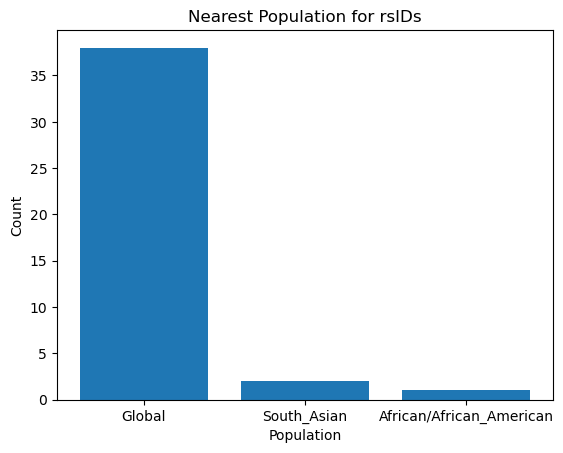

In [67]:
import matplotlib.pyplot as plt

# Count the occurrences of each population
population_counts = df['Nearest_Population'].value_counts()

# Plot
plt.bar(population_counts.index, population_counts.values)
plt.xlabel('Population')
plt.ylabel('Count')
plt.title('Nearest Population for rsIDs')
plt.show()

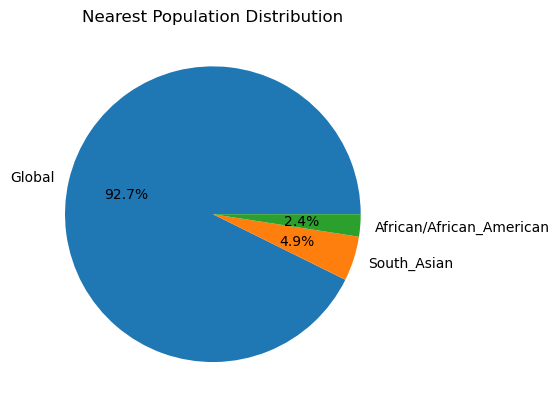

In [68]:
plt.pie(population_counts, labels=population_counts.index, autopct='%1.1f%%')
plt.title('Nearest Population Distribution')
plt.show()

In [43]:
# Find nearest population for each rsID
nearest_populations = []
for index, row in df.iterrows():
    distances = {}
    for population in ['Global', 'East_Asian', 'European(non-Finnish)', 'South_Asian', 'African/African_American']:
        distance = np.linalg.norm(row['Alt_Freq/MAF_K&H'] - row[population])
        distances[population] = distance
    nearest_population = min(distances, key=distances.get)
    nearest_populations.append(nearest_population)

df['Nearest_Population'] = nearest_populations
df

,rsID,Alt_Freq/MAF_K&H,Global,East_Asian,European(non-Finnish),South_Asian,African/African_American,Nearest_Population
0,rs2231142,0.102679,0.111900,0.298200,0.110900,0.090180,0.026770,European(non-Finnish)
1,rs4961,0.194399,0.198400,0.508000,0.198900,0.175000,0.075980,Global
2,rs1042713,0.373782,0.388300,0.527600,0.365200,0.448300,0.493500,European(non-Finnish)
3,rs7412,0.034903,0.074240,0.060500,0.078300,0.041640,0.105600,South_Asian
4,rs4673993,0.430195,0.319500,0.261700,0.328000,0.472500,0.120800,South_Asian
5,rs71647871,0.003653,0.011760,0.000067,0.012970,0.006593,0.002414,African/African_American
6,rs78769542,0.003247,0.000307,0.000156,0.000023,0.004678,0.000200,South_Asian
7,rs16969968,0.172078,0.301600,0.026760,0.335400,0.237600,0.056080,South_Asian
8,rs12777823,0.365260,0.190500,0.311900,0.151300,0.334500,0.249600,South_Asian
9,rs3745274,0.276380,0.256400,0.190500,0.240800,0.386900,0.377100,Global


In [37]:
# Calculate correlation coefficients for each population
correlations = {}
for population in ['Global', 'East_Asian', 'European(non-Finnish)', 'South_Asian', 'African/African_American']:
    correlation_coefficient = np.corrcoef(df['Alt_Freq/MAF_K&H'], df[population])[0, 1]
    correlations[population] = correlation_coefficient

# Print correlation coefficients
for population, correlation in correlations.items():
    print(f"Correlation coefficient (r) between K&H population and {population}: {correlation}")

Correlation coefficient (r) between K&H population and Global: 0.7743463292741067
Correlation coefficient (r) between K&H population and East_Asian: 0.3592265197121403
Correlation coefficient (r) between K&H population and European(non-Finnish): 0.7354317669117253
Correlation coefficient (r) between K&H population and South_Asian: 0.9499833435936661
Correlation coefficient (r) between K&H population and African/African_American: 0.716324626317353


In [82]:
import os

def extract_chr1_from_vcf(vcf_file):
    extracted_lines = []
    with open(vcf_file, 'r') as f:
        for line in f:
            if line.startswith('#') or line.split('\t')[0] == 'chr1':
                # Preserve header lines and lines containing 'chr1'
                extracted_lines.append(line.strip())

    return extracted_lines

# Directory containing the VCF files
directory = r'C:/Users/GenepoweRx_Madhu/OneDrive/Documents/LD_data/'

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.vcf'):
        vcf_file_path = os.path.join(directory, filename)
        extracted_lines = extract_chr1_from_vcf(vcf_file_path)
        
        # Write extracted lines to a new vcf file
        output_filename = os.path.splitext(filename)[0] + '_chr1.vcf'
        output_file_path = os.path.join(directory, output_filename)
        with open(output_file_path, 'w') as out_file:
            out_file.write('\n'.join(extracted_lines))

        print(f"Extracted lines from '{filename}' written to '{output_filename}'")


Extracted lines from 'KHAIGHGPTTL334_final.vcf' written to 'KHAIGHGPTTL334_final_chr1.vcf'
Extracted lines from 'KHAIGHGPTTL335_final.vcf' written to 'KHAIGHGPTTL335_final_chr1.vcf'
Extracted lines from 'KHAIGHGPTTL336_final.vcf' written to 'KHAIGHGPTTL336_final_chr1.vcf'
